### 2 Clean Data

In [8]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import statistics
import datetime
from sklearn import preprocessing

from pyensae.graphhelper import Corrplot

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt 

from sklearn.feature_extraction.text import CountVectorizer

import scipy.stats

from sklearn import preprocessing

from sklearn.cluster import AgglomerativeClustering



In [49]:
bt = pd.read_csv("bank_transactions.csv")      # Import the dataset
bt.dropna(inplace=True)                      # Dropping missing values 

In [50]:
# convert to timedate
bt.CustomerDOB = pd.to_datetime(bt.CustomerDOB)
bt.TransactionDate = pd.to_datetime(bt.TransactionDate)

In [51]:
def zeros(x):
    l = len(x)
    if l != 6:
        x = '0' * (6-l) + x
    return x

In [52]:
bt.TransactionTime = list(map(str,bt.TransactionTime))
bt.TransactionTime = list(map(zeros,bt.TransactionTime))
bt.TransactionTime = bt.TransactionTime.apply(lambda x: f'{x[:2]}:{x[2:4]}:{x[4:]}')
bt.TransactionTime = pd.to_datetime(bt.TransactionTime, format='%H:%M:%S')

In [53]:
bt.loc[bt.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = bt.loc[bt.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)
bt.drop(bt[bt.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True)

In [54]:
#calculating customer age
bt['CustomerAge'] = (( pd.to_datetime('today') - bt.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0)
bt['CustomerAge'] = bt['CustomerAge'].astype(int)

In [55]:
bt['TransactionAmount (INR)'] = bt['TransactionAmount (INR)'].astype(int)
bt['Utilisation'] = bt['CustAccountBalance'] - bt['TransactionAmount (INR)']

In [10]:
#to save
bt.to_pickle("bank.pkl")

In [4]:
#to load
bt = pd.read_pickle("bank.pkl")

### 2.1 Getting your data + feature engineering

In [56]:
#Define an empty dataframe
Features = pd.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)

#Number of transaction
Features["Num_of_Transaction"] = bt[["CustomerID","TransactionID"]].groupby("CustomerID").count()

#Transaction with balance > 100:
Features["Balance>100_USD"] = bt[["CustomerID","CustAccountBalance"]].groupby("CustomerID").apply(lambda x: (x>100).sum())


#Average Amount of the transactions:
Features["Average_Amount"] = bt[["CustomerID","TransactionAmount (INR)"]].groupby("CustomerID").agg(Average_Amount=("TransactionAmount (INR)",np.mean))


#Average Balance:
Features["Average_Balance"] = bt[["CustomerID","CustAccountBalance"]].groupby("CustomerID").agg(Average_Balance=("CustAccountBalance",np.mean))


#Utilisation = Average difference between the balance and the transaction amount:
pd.options.mode.chained_assignment = None      #Avoid the red banner
bt["Utilisation"] = bt["CustAccountBalance"]-bt["TransactionAmount (INR)"]  #create "Utilisation" column
Features["Utilisation"] = bt[["CustomerID","Utilisation"]].groupby("CustomerID").agg(Utilisation=("Utilisation",np.mean))  #calculate the mean  

#Mode od Gender of the customer:  
Features["gender"]=bt[["CustomerID","CustGender"]].groupby("CustomerID").agg(CustGender =("CustGender",statistics.mode))

#Most frequent location of the customer
Features["Most_Frequent_Location"] = bt[["CustomerID","CustLocation"]].groupby("CustomerID").agg(CustLocation =("CustLocation",statistics.mode))


### Adding 20 additional features

* 1 Customer age (median of the age per customer)
* 2 Maximum transaction of the customer
* 3 Minimun transaction of the customer
* 4 Important customer (Define as Average_Balance greater than 80% of the average balance of all customers
* 5 Number of Teen agers :  teen ager (Define  20 years before the last transaction registered )
* 6 Class Age ( young <= 25 ; 26 < grown-up <= 60  ; elderly > 60 )
* 7 Transaction with balance < 80:
* 8 Date of birth of the first costumer
* 9 Maximum Balance : the maximum balance value that a custumer has
* 10 Minimum Balance : the minimum balance value that a custumer has
* 11 Average transaction
* 12 Number of man
* 13 Number of woman
* 14 Place of last transaction
* 15 PLace of the first transaction
* 16 Number_transaction>median : number of transaction greter than the median of transactions
* 17 Date_last: Date of the last transaction
* 18 Transaction_st_dev : Standard deviation of the transactions of the cosumer
* 19 Number_transaction>q3 : Number of transaction grater than third quartile
* 20 Transaction_CV : Coefficient of varation of the transaction of the custumer

In [57]:
# 1)
Features["Costumer_age"] = bt[["CustomerID","CustomerAge"]].groupby("CustomerID").median()

# 2)
Features["Max_transaction"] = bt[["CustomerID","TransactionAmount (INR)"]].groupby("CustomerID").max()

# 3)
Features["Min_transaction"] = bt[["CustomerID","TransactionAmount (INR)"]].groupby("CustomerID").min()

# 4)
Features["Important_costumer"] = Features["Average_Balance"] > Features["Average_Balance"].quantile(.8)

# 5)
# First  set the date after that people born are teen ager 
d1 = datetime.datetime(max(bt.TransactionDate).year - 20 ,max(bt.TransactionDate).month , max(bt.TransactionDate).day)
bt['teen'] = bt.CustomerDOB > d1
# Create the variables
Features["Number_of_teenager"] = bt[["CustomerID","teen"]].groupby("CustomerID").agg(teen =("teen", sum )) 

# 6)
# Here  we  copy the variable age
Features["Class_Age"]  = Features["Costumer_age"]

# Set a single age age
Features.Class_Age[ Features["Class_Age"] <= 25]  = 0

Features.Class_Age[ (Features["Class_Age"] > 25) &  (Features["Class_Age"] <= 60) ]   = 1

Features.Class_Age[ Features["Class_Age"] > 60 ]  = 2


# 7)
Features["Balance<80_USD"] = bt[["CustomerID","CustAccountBalance"]].groupby("CustomerID")["CustAccountBalance"].apply(lambda x: (x<80).sum())

# 8)
Features["Date_of_birth"] = bt[["CustomerID","CustomerDOB"]].groupby("CustomerID").first()

# 9)
Features["Maximum_balance"] = bt[["CustomerID","CustAccountBalance"]].groupby("CustomerID").agg(Average_Balance=("CustAccountBalance",np.max))

# 10)
Features["Minimum_balance"] = bt[["CustomerID","CustAccountBalance"]].groupby("CustomerID").agg(Average_Balance=("CustAccountBalance",np.min))

# 11)
Features["Median_transaction"] = bt[["CustomerID","TransactionAmount (INR)"]].groupby("CustomerID").median()

# 12)
Features["Number_of_woman"] = bt[["CustomerID","CustGender", "TransactionAmount (INR)" ]].groupby("CustomerID")["CustGender"].apply(lambda x: (x == "F").sum())

# 13)
Features["Number_of_man"] = bt[["CustomerID","CustGender", "TransactionAmount (INR)" ]].groupby("CustomerID")["CustGender"].apply(lambda x: (x == "M").sum())

# 14) 

Features["Place_last"] = bt[["TransactionDate","CustomerID","CustLocation"]].sort_values(by="TransactionDate").groupby("CustomerID")["CustLocation"].last()

# 15)
Features["Place_first"] = bt[["TransactionDate","CustomerID","CustLocation"]].sort_values(by="TransactionDate").groupby("CustomerID")["CustLocation"].first()

# 16)
m = bt["TransactionAmount (INR)"].median()
Features["Number_transaction>median"] = bt[["TransactionAmount (INR)" ,"CustomerID" ]].groupby("CustomerID").apply( lambda x : (x>q).sum()  )

# 17)
Features["Date_last"] = bt[["TransactionDate","CustomerID"]].sort_values(by="TransactionDate").groupby("CustomerID").last()

# 18)
deviance = bt[["TransactionAmount (INR)" ,"CustomerID" ]].groupby("CustomerID").std()
deviance.fillna(value=0 , inplace = True )
Features["Transaction_st_dev"] = deviance

# 19)
q = bt["TransactionAmount (INR)"].quantile(.75)
Features["Number_transaction>q3"] = bt[["TransactionAmount (INR)" ,"CustomerID" ]].groupby("CustomerID").apply( lambda x : (x>q).sum()  )

# 20)
Features["Transaction_CV"] = bt[["CustomerID","TransactionAmount (INR)"]].groupby("CustomerID").agg(CustGender =("TransactionAmount (INR)", scipy.stats.variation ))


/Users/paolo/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1021: RuntimeWarning: invalid value encountered in double_scalars
  return a.std(axis, ddof=ddof) / a.mean(axis)


In [ ]:
#save
Features.to_pickle("Custumer.pkl")

In [6]:
#load
Custumer = pd.read_pickle("Custumer.pkl")

## 2.2 Choose your features (variables)!


Principal component analysis (PCA) allows us to summarize and to visualize the information in a data set containing individuals/observations described by multiple inter-correlated quantitative variables. Each variable could be considered as a different dimension. If we have more than 3 variables in your data sets, it could be very difficult to visualize a multidimensional hyperspace.


Principal component analysis is used to extract the important information from a multivariate  data table and to express this information as a set of few new variables called principal components. These new variables correspond to a linear combination of the originals. The number of principal components is less than or equal to the number of original variables.


The information in a given data set corresponds to the total variation it contains. The goal of PCA is to identify directions (or principal components) along which the variation in the data is maximal.

 In other words, PCA reduces the dimensionality of a multivariate quantitative dataset to a fewer number of  principal components, that can be visualized graphically, with minimal loss of information.

### To normalise or not to normalise?

In order to perform the PCA analysis we need to normalize the data because PCA associate Variance with information, colliding variables into Principal components that explain a percentage of the variance / information of our data.

In our case we have variables as Number of transaction supported around (1,..,6) and others as Utilisation that can assume really huge values in comparison.

Variance, being a not a normalized statistic , don't allow us to compare itself between others variable.

Then, in conclusion, we are going to normalize the data and compute the PCA.

In [12]:
scaler = preprocessing.MinMaxScaler() 
arr_scaled = scaler.fit_transform([Custumer.Utilisation.values]) 

In [13]:
columns = [ "Num_of_Transaction" , "Balance>100_USD"   , "Average_Amount" ,
            "Costumer_age"  , "Average_Balance" , "Utilisation" , "Maximum_balance" ,
            "Minimum_balance" , "Median_transaction" , "Number_of_woman" ,  "Number_of_man",
            "Number_of_teenager" , "Balance<80_USD"  , "Minimum_balance"  , 
            "Number_transaction>median" , "Number_transaction>q3"  ]

In [36]:
data_red = Custumer[columns] 

/Users/paolo/opt/anaconda3/lib/python3.9/site-packages/pyensae/graphhelper/linkage.py:43: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = linkage(D, method=method, metric=metric)


<AxesSubplot:>

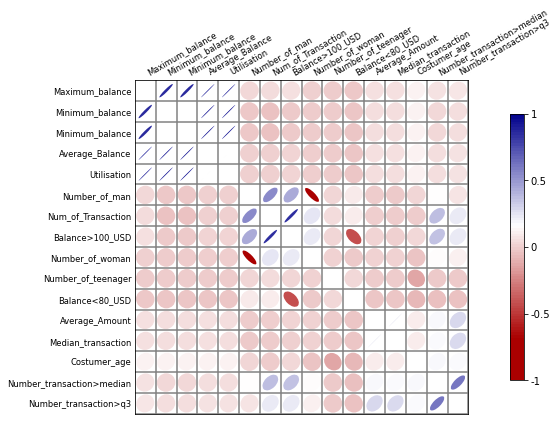

In [15]:
c = Corrplot(data_red)
c.plot(figsize=(12,6))

In [16]:
x = data_red.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
data_red = pd.DataFrame(x_scaled)

In [17]:
pca = PCA(n_components=5)
pca_features = pca.fit_transform(data_red)
 
print('Shape before PCA: ', data_red.shape)
print('Shape after PCA: ', pca_features.shape)

Shape before PCA:  (839081, 16)
Shape after PCA:  (839081, 5)


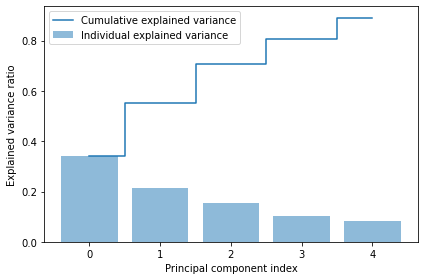

In [18]:
# Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_

# For visualizing the variance explained by each principal component.
# Compute the cumulative variance explained by each PCA
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Plots

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Comments:
Plots shown tha we need to use at least 3 Principal components in order to have at least 70% of the variance


# 2.3 Clustering!

In [19]:
model = AgglomerativeClustering(n_clusters=20, affinity='euclidean', linkage='single')

In [ ]:
age_balance_sample['cluster'] = model.fit_predict()

In [159]:
age_balance_sample = data_red
age_balance_sample = age_balance_sample.sample(2000)

/Users/paolo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


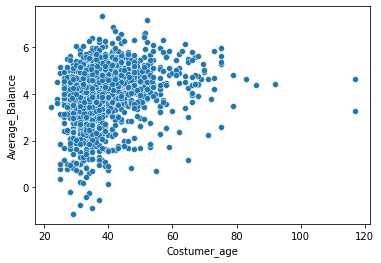

In [160]:
sns.scatterplot(x = age_balance_sample.Costumer_age, y = np.log10(age_balance_sample.Average_Balance));

In [161]:
model.fit_predict(age_balance_sample)
age_balance_sample['cluster'] = model.fit_predict(age_balance_sample)

In [173]:
model = KMeans(n_clusters= 4 )
age_balance_sample['cluster'] = model.fit_predict(age_balance_sample)

/Users/paolo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


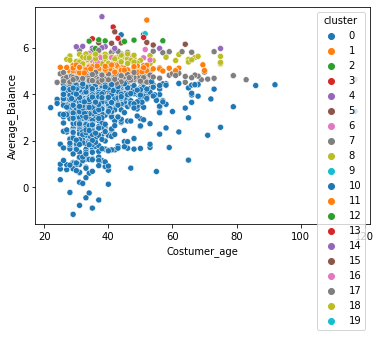

In [174]:
sns.scatterplot(x = age_balance_sample.Costumer_age,
                 y = np.log10(age_balance_sample.Average_Balance),
                 palette = "tab10" ,
                  hue=age_balance_sample.cluster);

In [171]:
sd = {}
for k in range(10, 100):
    model = KMeans(n_clusters=k)
    model.fit(age_balance_sample)
    sd[k] = model.inertia_

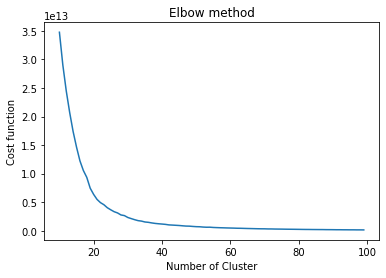

In [172]:
plt.figure()
plt.plot(list(sd.keys()), list(sd.values()))
plt.xlabel('Number of Cluster')
plt.ylabel('Cost function')
plt.title('Elbow method')
plt.show()

## 2.4 Analysing your results!

In [37]:
model = AgglomerativeClustering(n_clusters= 4, affinity='euclidean', linkage='single')

In [38]:
data = data_red.sample(10000)

In [39]:
data['cluster'] = model.fit_predict(data)

In [40]:
data['cluster'] = model.fit_predict(data)